# Convolutional Neural Network
- Now that we've understood the whole framework of training in Pytorch
- We can now focus on improving the architecture
- Before we dive deep into CNN, We've outline some guide questions for you to answer

1. What's the biggest problem of Multi-Layer Perceptron if we are going to extend into more than one hidden layer?

2. What's the innovation of Convolutional Neural Network?

3. What's a 2D convolution anyway?

4. When we say kernel size of 3, what does it mean?

5. What do we mean by channel?

6. How about depth?

7. What is padding?

8. What is stride?

9. How do we ensure that the output map would have the same size with the input?

10. If you are given input volume of 10x128x128, you convolved it with 1x3x3 (i.e. no. of channel first!) with Padding of 1, and Stride of 1, What is the expected output volume?

11. If you are given input volume of 3x227x227, you convolved it with 96x11x11 (i.e. no. of channel first!) with Padding of 0, and Stride of 4, What is the expected output volume?



## Load Typical Packages

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# For colab users
# from google.colab import drive

## Gather your dataset
- In this case, we want MNIST dataset.
- Fortunately, this is already built-in from torchvision package

In [3]:
from torchvision import datasets, transforms

# Check if CUDA at slot 0 is available or not. Otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Define a transform to augment the data. 
# Transform #1 = we want to convert everything into tensor format so that we can streamline pytorch packages
# Transform #2 = Normalize. This is used for data cleaning so that you can help the model perform better.
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

#Load your MNIST Dataset
# If you check the documentation of MNIST method, 
#              argument #1 = directory to save the fetched dataset
#              argument #2 (download)  = do we download if you don't have on the said directory?
#              argument #3 (train)     = what type of dataset?
#              argument #4 (transform) = which transformation do you like to do? 
train_set = datasets.MNIST('drive/My Drive/mnist', download=True, train=True, transform=transform)
test_set = datasets.MNIST('drive/My Drive/mnist', download=True, train=False, transform=transform)

We then try to check what does it look it

In [4]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: drive/My Drive/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

From above, we see that the `Dataset` object is like a folder structure. It provides you a mechanism to see its properties. 

*Recall*: In our previous lesson, we showed that training models in pytorch was done using the built-in `for` loop of Python. Our dataset that time was just using list of random numbers. 

But now that we are using real-world dataset via `Dataset` object. So how do we use it for model training?

We can use `DataLoader` utility to convert the dataset object into an `iterable` object which you can use within `for` loop later on.


In [5]:
# This is a function for you to change it from the dataset structure above into something iterable for the looping statement later on.
trainDataLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

Let's try to check what does one iteration look like.

In [6]:
trainIter = iter(trainDataLoader) # Convert it into python iterable built-in object

images, labels = trainIter.next() #Get the next element

print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


As you can see, torch dimensional format is as follows:  
dim0 = batch size  (i.e. number of images in one batch)  
dim1 = no. of channels  (i.e. number of color channel if you may, e.g. R,G,B)  
dim2 = width  (i.e. how wide the photo in pixel)  
dim3 = height (i.e. how tall the photo in pixel)   

Since the no. of channel is only one, we see that this is 'black-and-white' photo. It is not colored. Technically, this is called a grayscale image.

Note: If you are coming from tensorflow, they have different arrangement of dimension esp no. of channel

## Visualize the dataset
This is how our dataset looks like. Don't forget than a grayscale image is 2D array.

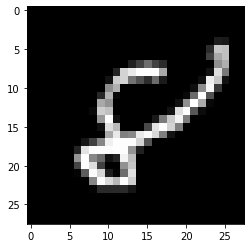

In [7]:
plt.gray()
plt.imshow(images[0].squeeze()) #Note: We get the image 0 from the batch. Thus, it becomes 3 dim. We would 'squeeze' so that it becomes 2 dim.

## NN Module

- this is where we define our Neural Network Architecture

In [8]:
import torch.nn as nn
import torch.nn.functional as F
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1,20,5,1) #No. of input channel,No. of output channel, Kernel Size,stride
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(500, 10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        
        x = x.view(-1, 4*4*50) # reshape
        x = self.relu3(self.fc1(x))
        
        x = self.softmax(self.fc2(x))
        
        return x

## Model Configurations

In [9]:
seed = 24 #Fave Number. Kobe == 24
torch.manual_seed(seed) # This is set in order to have reproducible and comparable results


D_in = 784 # Number of input neuron in layer 0 (input layer)
H1 = 150   # Number of neuron in layer 1
H2 = 48    # number of neuron in layer 2
D_out = 10 # number of neuron in layer 3 (output layer)

#model = MLP(D_in,H1,H2,D_out).to(device) #Note: We transferred it to GPU

model = LeNet()


epochs = 10 # Number of times it would repeat the whole training process

In [10]:
# Define the cost function
# criterion = torch.nn.MSELoss(reduction='sum')
# criterion = nn.NLLLoss() #This is good for classification task

criterion = nn.CrossEntropyLoss()
# Define how we would update the weights
optimizer = torch.optim.SGD(model.parameters(),lr=0.0001,momentum=0.9)

## Configure Tenorboard as Visualizer Board

In [11]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist_run_7')

## Model Training and Evaluation Framework v4
- At this point we are able to think of reusability and abstractions in mind
- For this tutorial, we would utilize the most famous plotting tool `Tensorboard`
- We now have to transfer it to GPU
- We showcase that these sets of code is reusable on a different Model

In [12]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

#We transferred both the model and data to GPU on trainer and evaluator
trainer = create_supervised_trainer(model,optimizer,criterion,device)
evaluator = create_supervised_evaluator(model,metrics={'accuracy':Accuracy(),
                                                      'loss':Loss(criterion)},device=device)

In [16]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(trainDataLoader)
    avg_accuracy = evaluator.state.metrics['accuracy']
    avg_loss = evaluator.state.metrics['loss']
    epoch = engine.state.epoch
    print("Epoch: {} train Loss: {:.4f} Acc: {:.4f}".format(epoch, avg_loss, avg_accuracy*100))
    
    # Update your plots
    writer.add_scalar('training loss', avg_loss, epoch * len(trainDataLoader))
    writer.add_scalar('training accuracy', avg_accuracy, epoch * len(trainDataLoader))
    
    pass

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(testDataLoader)
    avg_accuracy = evaluator.state.metrics['accuracy']
    avg_loss = evaluator.state.metrics['loss']
    epoch = engine.state.epoch

    print("Epoch: {} Val Loss: {:.4f} Acc: {:.4f}".format(epoch, avg_loss, avg_accuracy*100))
    
    # Update your plots
    writer.add_scalar('validation loss', avg_loss, epoch * len(testDataLoader))
    writer.add_scalar('validation accuracy', avg_accuracy, epoch * len(testDataLoader))

In [15]:
trainer.run(trainDataLoader, max_epochs=epochs)

Epoch: 1 train Loss: 2.2856 Acc: 33.8933
Epoch: 1 Val Loss: 2.2852 Acc: 34.7200
Epoch: 2 train Loss: 2.2809 Acc: 30.5250
Epoch: 2 Val Loss: 2.2804 Acc: 31.2600
Epoch: 3 train Loss: 2.2734 Acc: 26.5767
Epoch: 3 Val Loss: 2.2728 Acc: 27.0400
Epoch: 4 train Loss: 2.2598 Acc: 23.1467
Epoch: 4 Val Loss: 2.2588 Acc: 23.2800
Epoch: 5 train Loss: 2.2326 Acc: 25.3633
Epoch: 5 Val Loss: 2.2312 Acc: 25.7300
Epoch: 6 train Loss: 2.1842 Acc: 31.8567
Epoch: 6 Val Loss: 2.1822 Acc: 32.1600
Epoch: 7 train Loss: 2.1178 Acc: 38.3567
Epoch: 7 Val Loss: 2.1151 Acc: 38.4700
Epoch: 8 train Loss: 2.0372 Acc: 53.1700
Epoch: 8 Val Loss: 2.0336 Acc: 53.3000
Epoch: 9 train Loss: 1.9419 Acc: 62.7733
Epoch: 9 Val Loss: 1.9371 Acc: 62.9400
Epoch: 10 train Loss: 1.8773 Acc: 64.3817
Epoch: 10 Val Loss: 1.8724 Acc: 64.7200
